In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
import copy

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

## Ridership forecast

### Data gathering

In [2]:
bart_fcst = pd.read_csv('BART_ridership_forecast.csv')

In [3]:
bart_fcst

,Year,Average Weekday,Total Annual (M),Annual Change,Weight
0,19,413000,119.7,0.000,0.00
1,20,433700,126.4,0.050,0.30
2,21,443900,129.4,0.024,0.51
3,22,458400,133.6,0.033,0.66
4,23,473900,138.1,0.034,0.76
5,24,483500,140.9,0.020,0.83
6,25,490500,143.0,0.014,0.88
7,26,500100,145.8,0.020,0.92
8,27,535800,156.2,0.071,0.94
9,28,548000,159.7,0.023,0.96


In [4]:
riders = {}
year_min = 2015
year_max = 2018
periods = []

for year in range(year_min, year_max+1):
    folder = 'ridership_'+str(year)
    for month in range(12):
        month_str = ('0'+str(month+1))[-2:]
        sheet1 = 'Weekday OD'
        sheet2 = 'Saturday OD'
        sheet3 = 'Sunday OD'
        if year == 2018:
            filename = 'Ridership_'+str(year)+month_str
            if month+1 >= 2:
                sheet1 = 'Avg Weekday OD'
                sheet2 = 'Avg Saturday OD'
                sheet3 = 'Avg Sunday OD'                
        else:
            filename = 'Ridership_'+calendar.month_name[month+1]+str(year)
        path_to_file = folder+'/'+filename+'.xlsx'
        print(path_to_file)
        xlsx = pd.ExcelFile(path_to_file)
        df1 = pd.read_excel(xlsx, sheet1, skiprows=1)
        df2 = pd.read_excel(xlsx, sheet2, skiprows=1)
        df3 = pd.read_excel(xlsx, sheet3, skiprows=1)
        key = str(year) + month_str
        periods.append(key)
        riders[key] = [df1, df2, df3]

ridership_2015/Ridership_January2015.xlsx
ridership_2015/Ridership_February2015.xlsx
ridership_2015/Ridership_March2015.xlsx
ridership_2015/Ridership_April2015.xlsx
ridership_2015/Ridership_May2015.xlsx
ridership_2015/Ridership_June2015.xlsx
ridership_2015/Ridership_July2015.xlsx
ridership_2015/Ridership_August2015.xlsx
ridership_2015/Ridership_September2015.xlsx
ridership_2015/Ridership_October2015.xlsx
ridership_2015/Ridership_November2015.xlsx
ridership_2015/Ridership_December2015.xlsx
ridership_2016/Ridership_January2016.xlsx
ridership_2016/Ridership_February2016.xlsx
ridership_2016/Ridership_March2016.xlsx
ridership_2016/Ridership_April2016.xlsx
ridership_2016/Ridership_May2016.xlsx
ridership_2016/Ridership_June2016.xlsx
ridership_2016/Ridership_July2016.xlsx
ridership_2016/Ridership_August2016.xlsx
ridership_2016/Ridership_September2016.xlsx
ridership_2016/Ridership_October2016.xlsx
ridership_2016/Ridership_November2016.xlsx
ridership_2016/Ridership_December2016.xlsx
ridership_20

In [5]:
last_period = str(year_max)+'12'
columns = riders[last_period][0].columns[1:-1]

# Weekday entries
wk_ent_np = np.zeros(((year_max-year_min+1)*12, len(columns)))
# Saturday entries
st_ent_np = np.zeros(((year_max-year_min+1)*12, len(columns)))
# Sunday entries
sn_ent_np = np.zeros(((year_max-year_min+1)*12, len(columns)))

for t, period in enumerate(periods):
    for c, col in enumerate(columns):
        df1 = riders[period][0]
        if col in df1:
            wk_ent_np[t, c] =  riders[period][0][col].iloc[-1]
            st_ent_np[t, c] =  riders[period][1][col].iloc[-1]
            sn_ent_np[t, c] =  riders[period][2][col].iloc[-1]

wk_ent = pd.DataFrame(wk_ent_np, columns=columns)
st_ent = pd.DataFrame(st_ent_np, columns=columns)
sn_ent = pd.DataFrame(sn_ent_np, columns=columns)

wk_ent['period'] = periods
st_ent['period'] = periods
sn_ent['period'] = periods

wk_ent = wk_ent.set_index('period')
st_ent = st_ent.set_index('period')
sn_ent = sn_ent.set_index('period')

# Total week entries
tt_ent = 5*wk_ent + st_ent + sn_ent

In [6]:
wk_ent.head()

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SB,SO,MB,WD,OA,WS,ML,BE,PC,AN
period,,,,,,,,,,,,,,,,,,,,,
201501,4377.631579,8253.421053,4787.578947,4647.105263,11726.000000,5769.105263,9165.263158,12364.842105,13752.842105,6897.473684,...,3807.315789,5866.157895,6708.210526,3601.421053,1267.210526,0.0,0.0,0.0,0.0,0.0
201502,4593.894737,8456.947368,5001.368421,4632.842105,13404.578947,5936.842105,9354.947368,12790.421053,14156.210526,7438.105263,...,3857.473684,5911.789474,6927.157895,3561.315789,1325.052632,0.0,0.0,0.0,0.0,0.0
201503,4572.772727,8467.681818,4991.545455,4798.363636,13097.136364,5919.409091,9399.181818,12795.045455,14006.318182,7342.090909,...,3920.590909,6511.272727,7018.409091,3603.954545,1429.954545,0.0,0.0,0.0,0.0,0.0
201504,4587.181818,8576.954545,4987.681818,4829.681818,13402.818182,5944.227273,9488.181818,12791.863636,13993.681818,7360.636364,...,3895.045455,6737.181818,6888.090909,3670.090909,1462.272727,0.0,0.0,0.0,0.0,0.0
201505,4460.950000,8424.350000,4923.100000,4876.100000,12601.250000,5942.200000,9356.300000,12774.200000,13726.000000,7141.450000,...,3793.450000,7168.650000,6885.150000,3572.650000,1619.600000,0.0,0.0,0.0,0.0,0.0


In [7]:
st_ent.head()

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SB,SO,MB,WD,OA,WS,ML,BE,PC,AN
period,,,,,,,,,,,,,,,,,,,,,
201501,2291.00,3902.00,2398.40,2529.20,7425.60,3155.80,4425.00,4460.60,4679.00,3025.80,...,1789.60,4946.60,2986.4,1492.40,986.80,0.0,0.0,0.0,0.0,0.0
201502,2365.25,4163.75,2674.50,2827.50,9086.75,3387.00,4716.00,4953.50,5553.50,3522.75,...,1820.25,5125.25,3060.0,1477.75,769.25,0.0,0.0,0.0,0.0,0.0
201503,2504.75,4328.50,2706.50,2904.50,9341.00,3566.25,5011.50,5246.25,5408.00,3659.00,...,2073.75,5492.25,4030.5,1598.25,1056.00,0.0,0.0,0.0,0.0,0.0
201504,2349.75,4131.50,2594.25,2725.75,9810.75,3346.75,4947.75,4601.00,5110.25,3533.50,...,1827.75,5187.00,3145.5,1592.50,870.00,0.0,0.0,0.0,0.0,0.0
201505,2240.40,3909.20,2453.20,2746.00,8214.40,3246.00,4754.80,4354.60,4769.60,3366.00,...,1777.80,5988.80,3546.0,1347.40,918.80,0.0,0.0,0.0,0.0,0.0


In [8]:
sn_ent.head()

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SB,SO,MB,WD,OA,WS,ML,BE,PC,AN
period,,,,,,,,,,,,,,,,,,,,,
201501,1582.25,2312.75,1574.50,1764.75,4484.75,2128.25,3042.75,2736.5,3019.75,2502.75,...,1205.25,5558.75,1938.5,907.50,1442.00,0.0,0.0,0.0,0.0,0.0
201502,1620.50,2272.00,1522.25,1797.00,5144.25,2155.75,3077.50,2890.5,3264.00,2485.00,...,1199.00,5015.25,1990.0,894.00,1139.75,0.0,0.0,0.0,0.0,0.0
201503,1753.80,2424.20,1642.00,1887.60,5361.80,2321.40,3347.80,3342.4,3453.60,2774.20,...,1261.60,6136.60,2134.6,966.40,1481.60,0.0,0.0,0.0,0.0,0.0
201504,1643.00,2391.50,1604.25,1847.00,5213.25,2184.50,3197.50,2899.5,3207.25,2539.25,...,1218.00,6141.50,2147.5,900.75,1287.50,0.0,0.0,0.0,0.0,0.0
201505,1711.00,2580.80,1777.40,2095.00,5285.60,2303.20,3518.20,3104.6,3340.20,2739.60,...,1378.20,6205.40,2942.6,1166.40,1324.00,0.0,0.0,0.0,0.0,0.0


In [9]:
tt_ent.head()

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,SB,SO,MB,WD,OA,WS,ML,BE,PC,AN
period,,,,,,,,,,,,,,,,,,,,,
201501,25761.407895,47481.855263,27910.794737,27529.476316,70540.350000,34129.576316,53294.065789,69021.310526,76462.960526,40015.918421,...,22031.428947,39836.139474,38465.952632,20407.005263,8764.852632,0.0,0.0,0.0,0.0,0.0
201502,26955.223684,48720.486842,29203.592105,27788.710526,81253.894737,35226.960526,54568.236842,71796.105263,79598.552632,43198.276316,...,22306.618421,39699.447368,39685.789474,20178.328947,8534.263158,0.0,0.0,0.0,0.0,0.0
201503,27122.413636,49091.109091,29306.227273,28783.918182,80188.481818,35484.695455,55355.209091,72563.877273,78893.190909,43143.654545,...,22938.304545,44185.213636,41257.145455,20584.422727,9687.372727,0.0,0.0,0.0,0.0,0.0
201504,26928.659091,49407.772727,29136.909091,28721.159091,82038.090909,35252.386364,55586.159091,71459.818182,78285.909091,42875.931818,...,22520.977273,45014.409091,39733.454545,20843.704545,9468.863636,0.0,0.0,0.0,0.0,0.0
201505,26256.150000,48611.750000,28846.100000,29221.500000,76506.250000,35260.200000,55054.500000,71330.200000,76739.800000,41812.850000,...,22123.250000,48037.450000,40914.350000,20377.050000,10340.800000,0.0,0.0,0.0,0.0,0.0


In [10]:
total = pd.DataFrame(tt_ent.iloc[:,:-5].sum(axis=1), columns=['old'])
total['new'] = tt_ent.iloc[:,-5:].sum(axis=1)

In [11]:
total.tail()

,old,new
period,,
201808,2.306612e+06,41758.902174
201809,2.412969e+06,45134.894737
201810,2.390755e+06,48693.659091
201811,2.210456e+06,46566.934211
201812,2.164343e+06,44350.377778


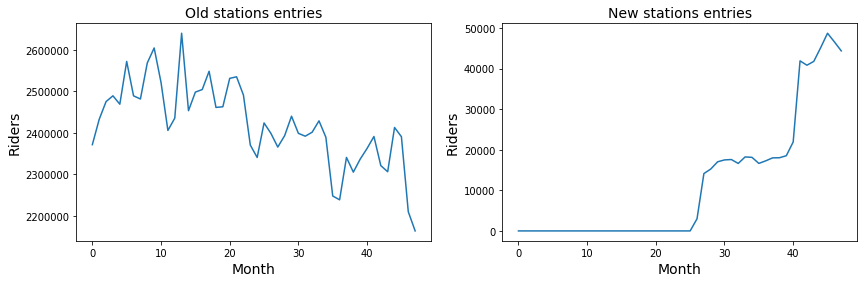

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
fontsize = 14
fontsize_leg = 12
l = len(total.index.values)

ax[0].plot(np.arange(l), total['old']) # total.index.values
ax[0].set_title('Old stations entries', fontsize=fontsize)
ax[0].set_xlabel('Month', fontsize=fontsize)
ax[0].set_ylabel('Riders', fontsize=fontsize)
#ax.legend(loc = 'upper left', fontsize = fontsize_leg)
#ax[0].set_xticklabels(total.index.values, rotation=90)

ax[1].plot(np.arange(l), total['new'])
ax[1].set_title('New stations entries', fontsize=fontsize)
ax[1].set_xlabel('Month', fontsize=fontsize)
ax[1].set_ylabel('Riders', fontsize=fontsize)
#ax.legend(loc = 'upper left', fontsize = fontsize_leg)
#ax[1].set_xticklabels(total.index.values, rotation=90)
plt.savefig('old_and_new.eps', format='eps')

plt.show()

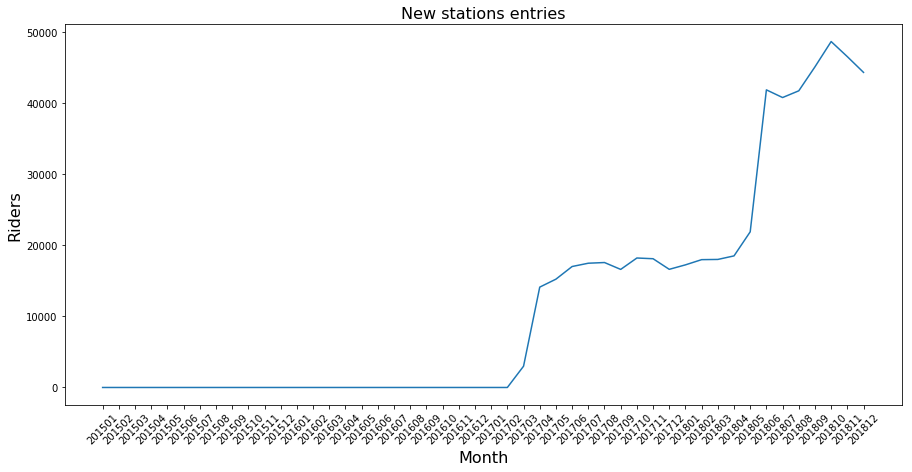

In [13]:
fig, ax = plt.subplots(figsize=(15,7))
fontsize = 16
fontsize_leg = 12

ax.plot(total.index.values, total['new'])
ax.set_title('New stations entries', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
#ax.legend(loc = 'upper left', fontsize = fontsize_leg)
ax.set_xticklabels(total.index.values, rotation=45)
plt.show()

### Forecast

In [14]:
old_diff = total['old'].diff()[1:]

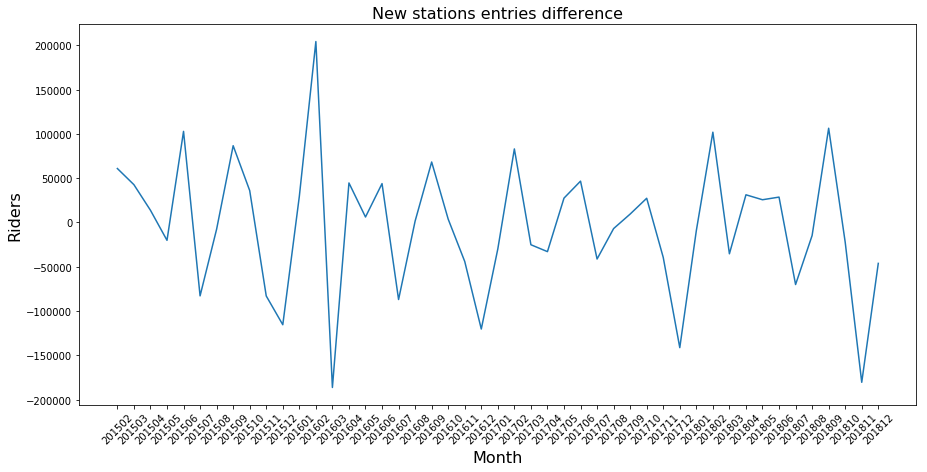

In [15]:
fig, ax = plt.subplots(figsize=(15,7))
fontsize = 16
fontsize_leg = 12

ax.plot(total.index.values[1:], old_diff)
ax.set_title('New stations entries difference', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
#ax.legend(loc = 'upper left', fontsize = fontsize_leg)
ax.set_xticklabels(total.index.values[1:], rotation=45)
plt.show()

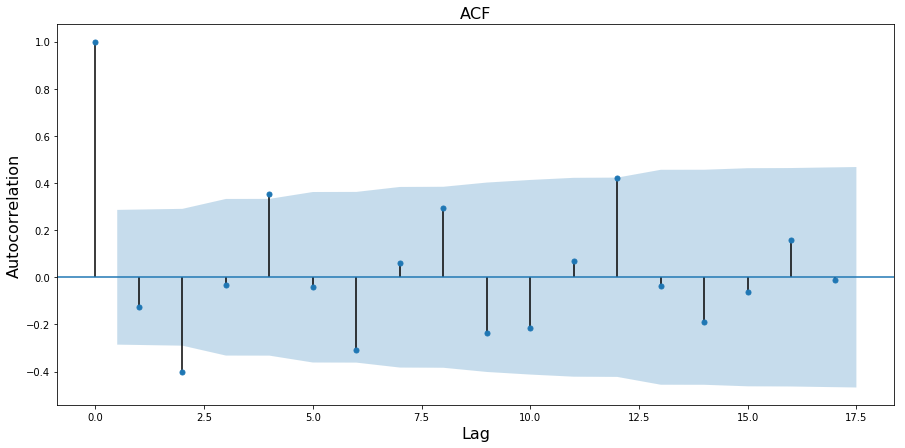

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
fontsize = 16
fontsize_leg = 12

plot_acf(old_diff, ax=ax)
ax.set_title('ACF', fontsize=fontsize)
ax.set_xlabel("Lag", fontsize=fontsize)
ax.set_ylabel("Autocorrelation", fontsize=fontsize)
plt.show()

In [17]:
model = SARIMAX(old_diff, order=(2,0,0), seasonal_order=(1,1,0,12)) # dist='StudentsT', trend='t'
model_fit = model.fit()
resid = model_fit.resid

In [18]:
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                old   No. Observations:                   47
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -429.877
Date:                            Fri, 11 Oct 2019   AIC                            867.754
Time:                                    11:58:16   BIC                            873.976
Sample:                                         0   HQIC                           869.902
                                             - 47                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6035      0.118     -5.098      0.000      -0.836      -0.371
ar.L2         -0.4795      0.108   

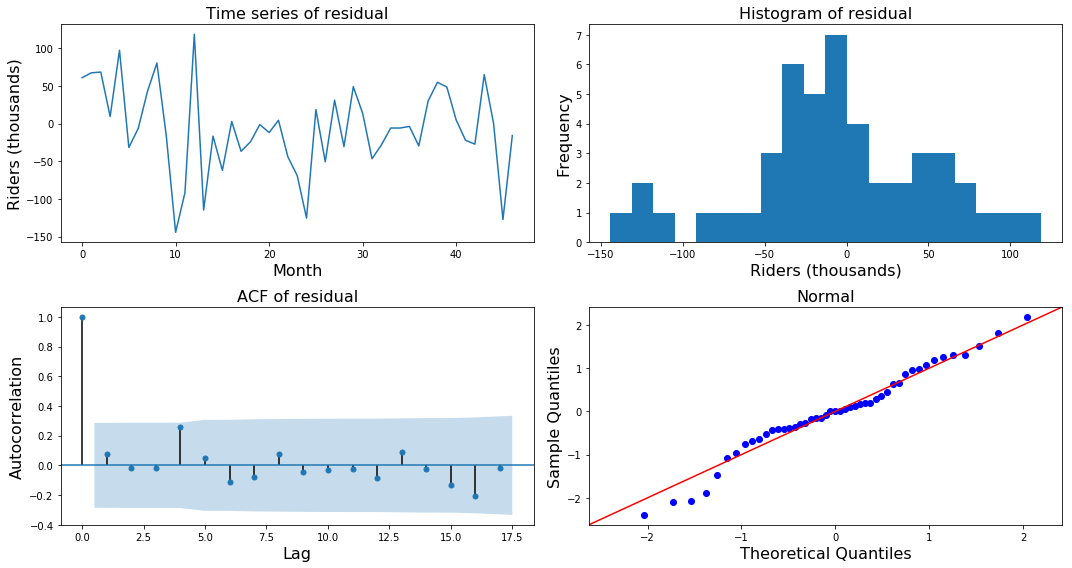

In [19]:
mu, sigma = stats.norm.fit(np.array(resid))

fig, ax = plt.subplots(2,2, figsize=(15,8))
fontsize = 16
data_plot = np.array(resid)/1e3

# Time series
ax[0,0].plot(data_plot)
ax[0,0].set_title('Time series of residual', fontsize=fontsize)
ax[0,0].set_xlabel('Month', fontsize=fontsize)
ax[0,0].set_ylabel('Riders (thousands)', fontsize=fontsize)

# Histogram
ax[0,1].hist(data_plot, bins=20)
ax[0,1].set_title('Histogram of residual', fontsize=fontsize)
ax[0,1].set_xlabel('Riders (thousands)', fontsize=fontsize)
ax[0,1].set_ylabel('Frequency', fontsize=fontsize)

# ACF
plot_acf(data_plot, ax=ax[1,0])
ax[1,0].set_title('ACF of residual', fontsize=fontsize)
ax[1,0].set_xlabel("Lag", fontsize=fontsize)
ax[1,0].set_ylabel("Autocorrelation", fontsize=fontsize)

# QQplot
sm.qqplot(data_plot, stats.norm, loc=mu, scale=sigma, line='45', fit=True, ax=ax[1,1])
ax[1,1].set_title('Normal', fontsize=fontsize)
ax[1,1].set_xlabel("Theoretical Quantiles", fontsize=fontsize)
ax[1,1].set_ylabel("Sample Quantiles", fontsize=fontsize)

fig.tight_layout()

plt.savefig('residual.png')
#fig.savefig('performance_'+str(shift)+'_weeks'+'.png')

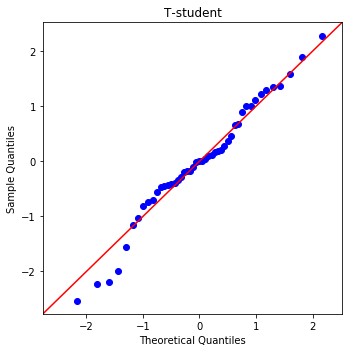

In [20]:
# T-student parameters
df, loc, scale = stats.t.fit(np.array(resid))

fig, ax = plt.subplots(figsize=(5,5))
fontsize = 16

# T-distribution (zoom)
sm.qqplot(data_plot, stats.t, distargs=(df,), loc=loc, scale=scale, line='45', fit=True, ax=ax)
ax.set_title('T-student')

fig.tight_layout()
#fig.savefig('qqplot_t.png')
plt.show()


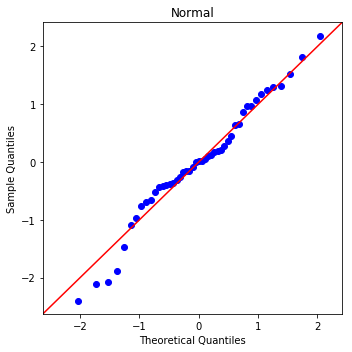

In [21]:
# Normal parameters
mu, sigma = stats.norm.fit(np.array(resid))

fig, ax = plt.subplots(figsize=(5,5))
fontsize = 16

# T-distribution (zoom)
sm.qqplot(data_plot, stats.norm, loc=mu, scale=sigma, line='45', fit=True, ax=ax)
ax.set_title('Normal')

fig.tight_layout()
#fig.savefig('qqplot_t.png')
plt.show()

In [22]:
scale

54617.843548456716

#### Expected forecast with no adjustment

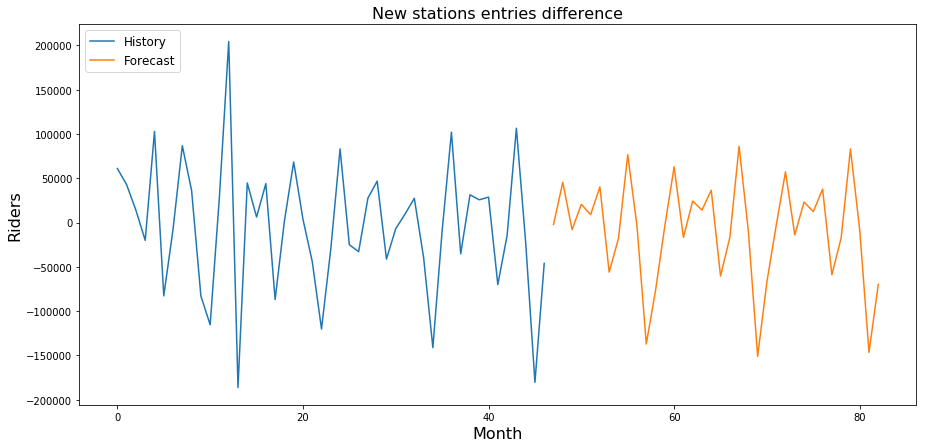

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
fontsize = 16
fontsize_leg = 12
history = len(old_diff)
forecast = 36

ax.plot(np.arange(history), old_diff, label='History')
ax.plot(np.arange(history, history+forecast), model_fit.forecast(forecast), label='Forecast')
ax.set_title('New stations entries difference', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
ax.legend(loc = 'upper left', fontsize = fontsize_leg)
plt.show()


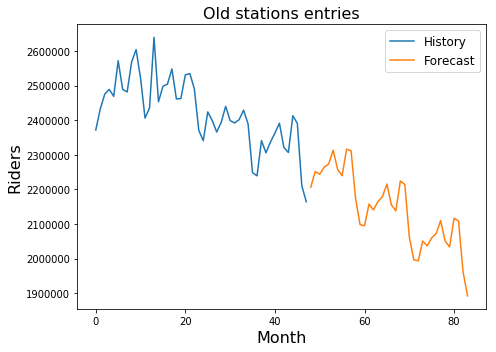

In [24]:
history = len(total['old'])
forecast = 36
pred_diff = model_fit.forecast(forecast)
total_last = total['old'].iloc[-1] + total['new'].iloc[-1]

pred_total_old = total_last + np.cumsum(pred_diff)

fig, ax = plt.subplots(figsize=(7,5))
fontsize = 16
fontsize_leg = 12

ax.plot(np.arange(history), total['old'], label='History')
ax.plot(np.arange(history, history+forecast), pred_total_old, label='Forecast')
ax.set_title('Old stations entries', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
ax.legend(loc = 'upper right', fontsize = fontsize_leg)

fig.tight_layout()
fig.savefig('SARIMA_forecast.eps')
plt.show()

#### Expected forecast with adjustment

In [25]:
history = len(old_diff)
forecast = (33-18)*12
pred_diff = np.array(model_fit.forecast(forecast))
pred_total_old = np.array(total['old'].iloc[-1] + np.cumsum(pred_diff))
pred_diff_adj = np.zeros(len(pred_diff))

In [26]:
bart_fcst

,Year,Average Weekday,Total Annual (M),Annual Change,Weight
0,19,413000,119.7,0.000,0.00
1,20,433700,126.4,0.050,0.30
2,21,443900,129.4,0.024,0.51
3,22,458400,133.6,0.033,0.66
4,23,473900,138.1,0.034,0.76
5,24,483500,140.9,0.020,0.83
6,25,490500,143.0,0.014,0.88
7,26,500100,145.8,0.020,0.92
8,27,535800,156.2,0.071,0.94
9,28,548000,159.7,0.023,0.96


In [27]:
prev = 0
pred_diff_cum = np.cumsum(pred_diff)
for i in range(int(forecast/12)):
    bart_pchange = 0
    bart_weight = 1
    last_riders = total_last + prev
    if i in bart_fcst.index:
        bart_pchange = bart_fcst.loc[i, 'Annual Change']
        bart_weight = bart_fcst.loc[i, 'Weight']
    model_change = pred_diff_cum[12*(i+1)-1] - prev
    bart_change = last_riders*bart_pchange
    prev = pred_diff_cum[12*(i+1)-1]
    final_change = bart_change*bart_weight + model_change*(1-bart_weight)
    pred_diff_adj[12*i:12*(i+1)] = pred_diff[12*i:12*(i+1)] + (final_change - model_change)/12

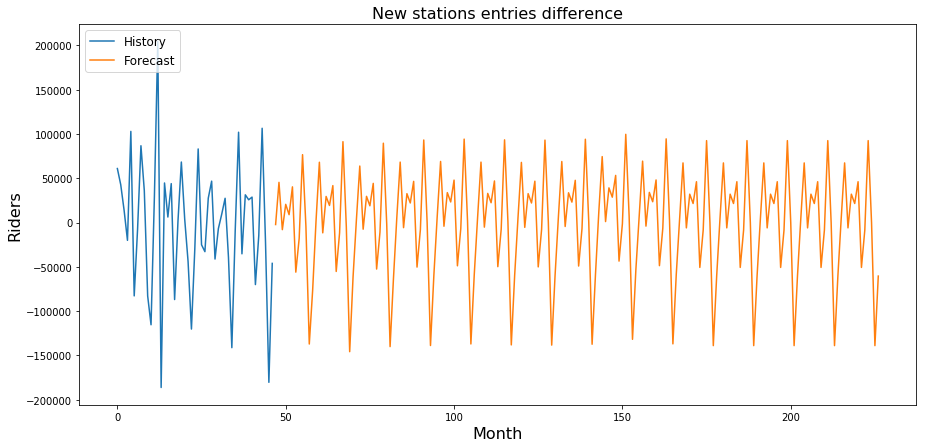

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
fontsize = 16
fontsize_leg = 12
history = len(old_diff)

ax.plot(np.arange(history), old_diff, label='History')
ax.plot(np.arange(history, history+forecast), pred_diff_adj, label='Forecast')
ax.set_title('New stations entries difference', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
ax.legend(loc = 'upper left', fontsize = fontsize_leg)
plt.show()

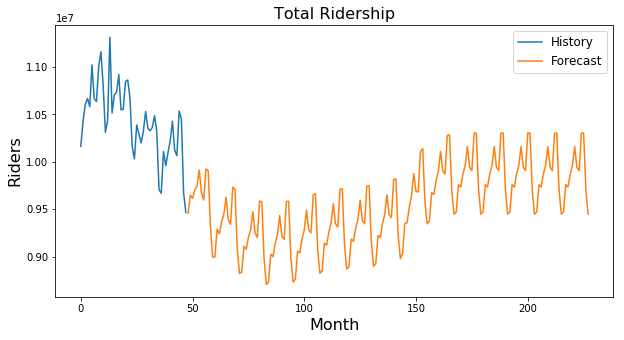

In [29]:
history = len(total['old'])
hist_total = (total['old']+ total['new'])*30/7
pred_total_adj = (total_last + np.cumsum(pred_diff_adj))*30/7

fig, ax = plt.subplots(figsize=(10,5))
fontsize = 16
fontsize_leg = 12

ax.plot(np.arange(history), hist_total, label='History')
ax.plot(np.arange(history, history+forecast), pred_total_adj, label='Forecast')
ax.set_title('Total Ridership', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
ax.legend(loc = 'upper right', fontsize = fontsize_leg)
plt.show()


### Simulations

In [30]:
n_sim = 1000
innovations = stats.norm.rvs(loc=0, scale=sigma, size=(n_sim, forecast))
sim_diff = innovations + pred_diff_adj
sim_total = (total_last + np.cumsum(sim_diff, axis=1))*30/7

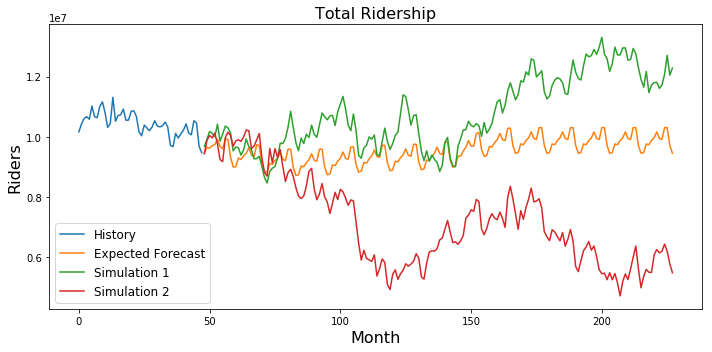

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
fontsize = 16
fontsize_leg = 12

ax.plot(np.arange(history), hist_total, label='History')
ax.plot(np.arange(history, history+forecast), pred_total_adj, label='Expected Forecast')
ax.plot(np.arange(history, history+forecast), sim_total[0], label='Simulation 1')
ax.plot(np.arange(history, history+forecast), sim_total[2], label='Simulation 2')
ax.set_title('Total Ridership', fontsize=fontsize)
ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Riders', fontsize=fontsize)
ax.legend(loc = 'down left', fontsize = fontsize_leg)

fig.tight_layout()
fig.savefig('forecast_and_simulations.eps', format='eps')
plt.show()
